In [ ]:
0
#import modules
import torch
from torch import nn
import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
#transform data
data_transform = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

In [ ]:
#download data
train_data = datasets.CIFAR10(root="data",
                              train=True,
                              transform=data_transform,
                              download=True,
                              target_transform=None)
test_data = datasets.CIFAR10(root="data",
                             train=False,
                             transform=data_transform,
                             download=True,
                             target_transform=None)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
len(train_data),len(test_data)

(50000, 10000)

In [ ]:
image,label = train_data[0]
image,label

(tensor([[[0.2314, 0.2157, 0.1843,  ..., 0.5922, 0.5843, 0.5804],
          [0.1882, 0.1725, 0.1412,  ..., 0.5608, 0.5569, 0.5569],
          [0.1059, 0.0902, 0.0588,  ..., 0.5020, 0.5020, 0.5059],
          ...,
          [0.7020, 0.6941, 0.6824,  ..., 0.4196, 0.3843, 0.3647],
          [0.6980, 0.6902, 0.6706,  ..., 0.5176, 0.4667, 0.4431],
          [0.6941, 0.6863, 0.6667,  ..., 0.5647, 0.5098, 0.4824]],
 
         [[0.2431, 0.2275, 0.1961,  ..., 0.4902, 0.4863, 0.4863],
          [0.2039, 0.1843, 0.1529,  ..., 0.4510, 0.4510, 0.4510],
          [0.1216, 0.1020, 0.0627,  ..., 0.3686, 0.3765, 0.3765],
          ...,
          [0.5490, 0.5333, 0.5059,  ..., 0.2863, 0.2588, 0.2471],
          [0.5608, 0.5451, 0.5176,  ..., 0.3882, 0.3451, 0.3216],
          [0.5647, 0.5490, 0.5216,  ..., 0.4392, 0.3882, 0.3608]],
 
         [[0.2471, 0.2314, 0.1961,  ..., 0.4000, 0.4039, 0.4039],
          [0.2039, 0.1882, 0.1529,  ..., 0.3529, 0.3569, 0.3608],
          [0.1216, 0.1020, 0.0627,  ...,

In [ ]:
class_names = train_data.classes
class_names

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [ ]:
class_to_idx = train_data.class_to_idx
class_to_idx

{'airplane': 0,
 'automobile': 1,
 'bird': 2,
 'cat': 3,
 'deer': 4,
 'dog': 5,
 'frog': 6,
 'horse': 7,
 'ship': 8,
 'truck': 9}

(-0.5, 63.5, 63.5, -0.5)

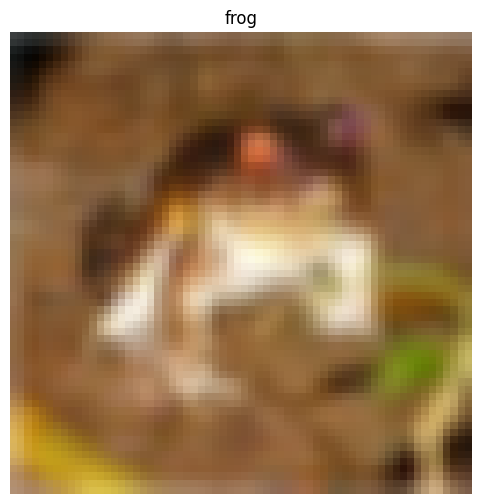

In [ ]:
plt.figure(figsize=(6,6))
plt.imshow(image.permute(1,2,0))
plt.title(class_names[label])
plt.axis("off")

In [ ]:
image.shape

torch.Size([3, 64, 64])

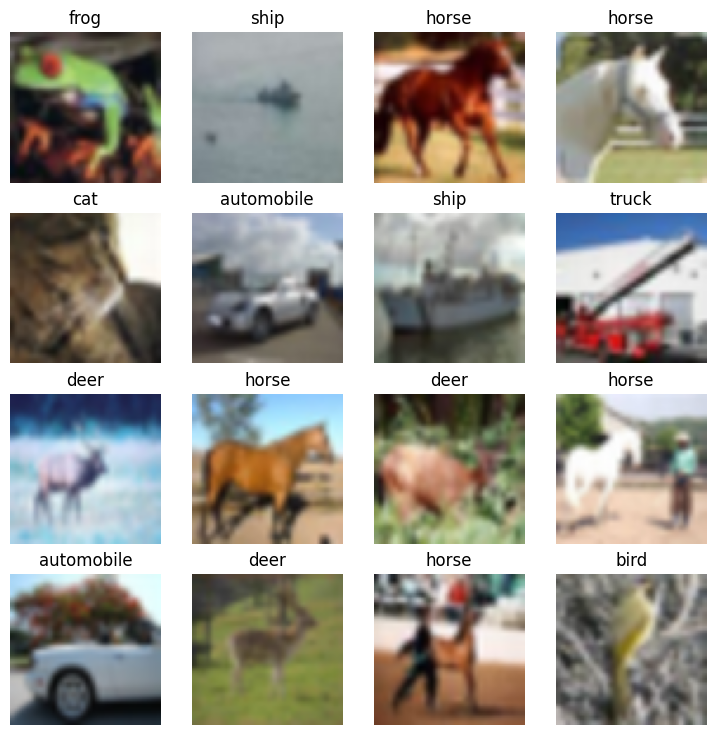

In [ ]:
#plot a random sample
torch.manual_seed(42)
fig = plt.figure(figsize=(9,9))
rows,cols = 4,4
for i in range(1,rows*cols+1):
  random_idx = torch.randint(0,len(train_data),size=[1]).item()
  img,label = train_data[random_idx]
  fig.add_subplot(rows,cols,i)
  plt.imshow(img.permute(1,2,0))
  plt.title(class_names[label])
  plt.axis("off")

In [ ]:
#setup dataloader
from torch.utils.data import DataLoader
import os
NUM_WORKERS = os.cpu_count()
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=32,
                              shuffle=True,
                              num_workers = NUM_WORKERS,
                              )
test_dataloader = DataLoader(dataset=test_data,
                             batch_size=32,
                             shuffle=False,
                             num_workers = NUM_WORKERS)
train_dataloader,test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7f272e440490>,
 <torch.utils.data.dataloader.DataLoader at 0x7f272e442a70>)

In [ ]:
len(train_dataloader),len(test_dataloader)

(1563, 313)

In [ ]:
#plot a images in dataloader
train_features_batch,train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape,train_labels_batch.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

In [ ]:
#build an baseline model
class CIFAR10Model(nn.Module):
  def __init__(self,
               input_shape:int,
               hidden_units:int,
               output_shape:int):
    super().__init__()
    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels = input_shape,
               out_channels=hidden_units,
               kernel_size=1,
               stride=1,
               padding=0),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
               out_channels=hidden_units,
               kernel_size=1,
               stride=1,
               padding=0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )
    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(in_channels = hidden_units,
               out_channels=hidden_units,
               kernel_size=1,
               stride=1,
               padding=0),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
               out_channels=hidden_units,
               kernel_size=1,
               stride=1,
               padding=0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )
    self.Classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features = hidden_units*16*16,
                  out_features = output_shape)
    )
  def forward(self,x):
    return self.Classifier(self.conv_block_2(self.conv_block_1(x)))

In [ ]:
#instance for the model
model_0 = CIFAR10Model(input_shape=3,
                  hidden_units=10,
                  output_shape = len(class_names))
model_0

CIFAR10Model(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(1, 1), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(1, 1), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(1, 1), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(1, 1), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (Classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2560, out_features=10, bias=True)
  )
)

In [ ]:
#dummay pass
image_batch,label_batch = next(iter(train_dataloader))
image_batch.shape,label_batch.shape
model_0(image_batch)

tensor([[ 0.0379,  0.1323,  0.0963, -0.1249,  0.0395,  0.0272, -0.1950, -0.0631,
          0.1209, -0.0876],
        [ 0.0362,  0.1299,  0.0936, -0.1272,  0.0428,  0.0250, -0.1964, -0.0600,
          0.1198, -0.0886],
        [ 0.0357,  0.1307,  0.0960, -0.1249,  0.0426,  0.0252, -0.1984, -0.0635,
          0.1204, -0.0889],
        [ 0.0382,  0.1320,  0.0968, -0.1262,  0.0408,  0.0258, -0.1945, -0.0627,
          0.1204, -0.0888],
        [ 0.0368,  0.1287,  0.0985, -0.1270,  0.0411,  0.0300, -0.2016, -0.0617,
          0.1194, -0.0861],
        [ 0.0381,  0.1315,  0.0926, -0.1246,  0.0414,  0.0297, -0.1968, -0.0626,
          0.1196, -0.0876],
        [ 0.0391,  0.1318,  0.0923, -0.1240,  0.0395,  0.0283, -0.1978, -0.0615,
          0.1216, -0.0878],
        [ 0.0380,  0.1314,  0.0945, -0.1259,  0.0418,  0.0277, -0.1956, -0.0638,
          0.1225, -0.0879],
        [ 0.0367,  0.1296,  0.0983, -0.1268,  0.0400,  0.0300, -0.1975, -0.0627,
          0.1199, -0.0883],
        [ 0.0375,  

In [ ]:
#setup loss fn and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(),lr=0.001)

In [ ]:
#create funnction for test loop and train loop
#test_step()
#train_step()

In [ ]:
#train_step()
def train_step(model:torch.nn.Module,
               dataloader:torch.utils.data.DataLoader,
               loss_fn:torch.nn.Module,
               optimizer:torch.optim.Optimizer,
               device:'cpu'):

  model.train()
  train_loss,correct_prediction,total_prediction = 0,0,0
  for batch,(X,y) in enumerate(dataloader):
    X,y = X.to(device),y.to(device)
    y_pred = model(X)
    loss = loss_fn(y_pred,y)
    train_loss += loss.item()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    y_pred_class = torch.argmax(torch.softmax(y_pred,dim=1),dim=1)
    correct_prediction += (y_pred_class==y).sum().item()
    total_prediction +=y.size(0)
  train_loss /= len(dataloader)
  train_acc = correct_prediction/total_prediction
  return train_loss,train_acc



In [ ]:
#test_step()
def test_step(model:torch.nn.Module,
              dataloader:torch.utils.data.DataLoader,
              loss_fn:torch.nn.Module,
              device:"cpu"):
  test_loss,correct_prediction,total_prediction = 0,0,0
  model.eval()
  with torch.inference_mode():
    for batch,(X,y) in enumerate(dataloader):
      X,y = X.to(device),y.to(device)
      test_pred_logits = model(X)
      loss = loss_fn(test_pred_logits,y)
      test_loss += loss.item()
      test_pred_labels = test_pred_logits.argmax(dim=1)
      correct_prediction += (test_pred_labels == y).sum().item()
      total_prediction += y.size(0)
    test_loss /= len(dataloader)
    test_acc = correct_prediction / total_prediction
    return test_loss,test_acc


In [ ]:
#train() function to combine train_step and test_step
from tqdm.auto import tqdm
def train(model:torch.nn.Module,
          train_dataloader:torch.utils.data.DataLoader,
          test_dataloader:torch.utils.data.DataLoader,
          optimizer:torch.optim.Optimizer,
loss_fn:torch.nn.Module,
          epochs:int,
          device='cpu'):

  #create an empty results
  results = {"train_loss":[],
             "train_acc":[],
             "test_loss":[],
             "test_acc":[]}
  #loop through training and testing of number of epochs
  for epoch in tqdm(range(epochs)):
    train_loss,train_acc = train_step(model=model,
                                      dataloader=train_dataloader,
                                      loss_fn=loss_fn,
                                      optimizer=optimizer,
                                      device=device)
    test_loss,test_acc = test_step(model=model,
                                   dataloader=test_dataloader,
                                   loss_fn=loss_fn,
                                   device=device)
    #print what happen
    print(f"epoch:{epoch} | train_loss:{train_loss:.3f} | train_acc:{train_acc:.3f} | test_loss:{test_loss:.3f} | test_acc:{test_acc:.3f}")

    #update the results
    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)
  return results

In [ ]:
#train and evaluate model
torch.manual_seed(42)

NUM_EPOCHS = 5

from timeit import default_timer as timer
start_timer = timer()

model_0_results = train(model=model_0,
                        train_dataloader = train_dataloader,
                        test_dataloader=test_dataloader,
                        loss_fn = loss_fn,
                        optimizer=optimizer,
                        epochs=NUM_EPOCHS)

end_timer=timer()
#print the training time
print(f"total training time = {end_timer - start_timer:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

epoch:0 | train_loss:1.903 | train_acc:0.312 | test_loss:1.717 | test_acc:0.388
epoch:1 | train_loss:1.657 | train_acc:0.416 | test_loss:1.599 | test_acc:0.435
epoch:2 | train_loss:1.578 | train_acc:0.446 | test_loss:1.543 | test_acc:0.457
epoch:3 | train_loss:1.534 | train_acc:0.461 | test_loss:1.508 | test_acc:0.472
epoch:4 | train_loss:1.498 | train_acc:0.474 | test_loss:1.497 | test_acc:0.471
total training time = 645.110 seconds


In [ ]:
model_0_results

{'train_loss': [1.9926695311138132,
  1.8050949643684822,
  1.7316884557482377,
  1.673796819786345,
  1.6269151031856572],
 'train_acc': [0.27924, 0.36276, 0.39238, 0.41018, 0.42558],
 'test_loss': [1.843405349947774,
  1.758339295752894,
  1.6953575546368242,
  1.652592486085983,
  1.6105462324124176],
 'test_acc': [0.3512, 0.379, 0.3968, 0.4141, 0.4293]}

In [ ]:
#plot the loss curves
#plot the loss curves
def plot_loss_curves(results):
  """plot training curves of a results dictionary"""
  #get the loss values of the distionary(train and test)
  loss = results["train_loss"]
  test_loss = results["test_loss"]

  #get the accuracy values of the dictionary
  accuracy = results["train_acc"]
  test_accuracy = results["test_acc"]

  #figure out how many epochs there were
  epochs = range(len(results["train_loss"]))

  #setup a plot
  plt.figure(figsize=(15,7))

  #plot the loss
  plt.subplot(1,2,1)
  plt.plot(epochs,loss,label = "train_loss")
  plt.plot(epochs,test_loss,label="test_loss")
  plt.title("loss")
  plt.xlabel("Epochs")
  plt.legend()

  #plot the accuracy
  plt.subplot(1,2,2)
  plt.plot(epochs,accuracy,label="train_accuracy")
  plt.plot(epochs,test_accuracy,label="test_accuracy")
  plt.title("Accuracy")
  plt.xlabel("Epochs")
  plt.legend()


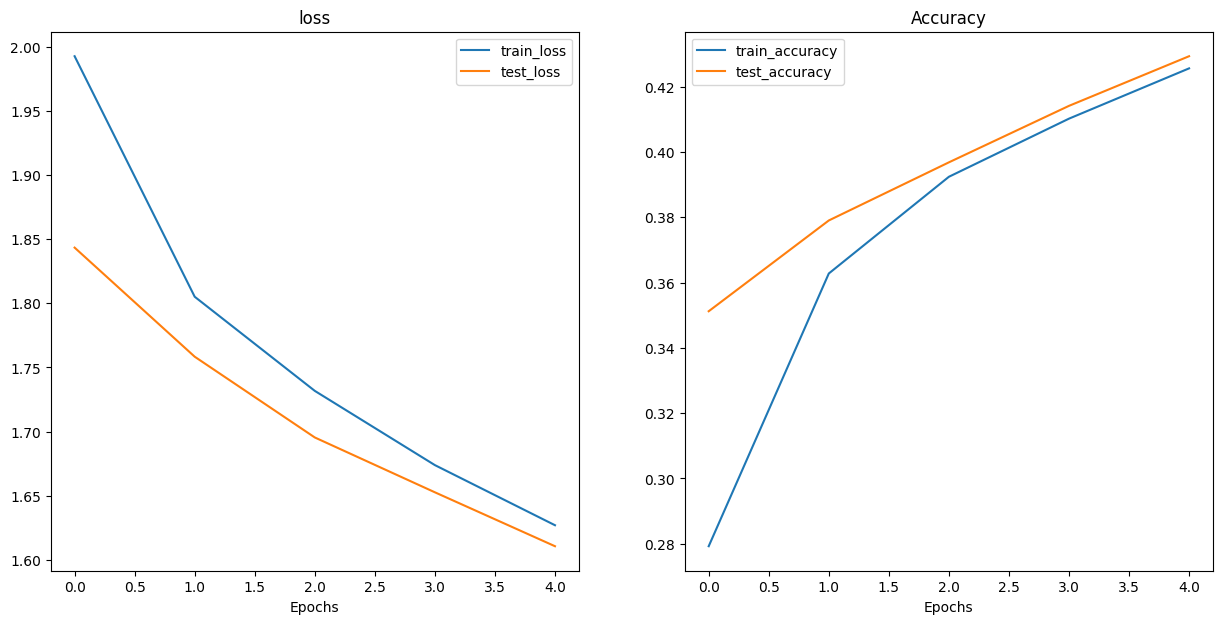

In [ ]:
plot_loss_curves(model_0_results)

In [ ]:
#make and evaluate random predictions with model
def make_predictions(model:torch.nn.Module,
                     data:list,
                     device:torch.device='cpu'):
  pred_probs = []
  model.eval()
  with torch.inference_mode():
    for sample in data:
      sample = torch.unsqueeze(sample,dim=0)
      pred_logit  = model(sample)
      pred_prob = torch.softmax(pred_logit.squeeze(),dim=0)
      pred_probs.append(pred_prob)
  return torch.stack(pred_probs)

import random
torch.manual_seed(42)
test_samples = []
test_labels = []
for sample,label in random.sample(list(test_data),k=9):
  test_samples.append(sample)
  test_labels.append(label)




Text(0.5, 1.0, 'automobile')

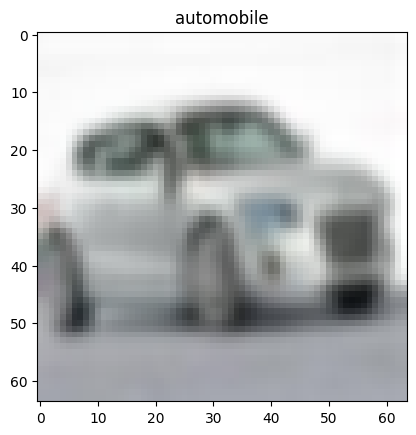

In [ ]:
plt.imshow(test_samples[1].squeeze().permute(1,2,0))
plt.title(class_names[test_labels[1]])

In [ ]:
#make predictions
torch.manual_seed(42)
pred_probs = make_predictions(model=model_0,
                             data=test_samples)
pred_probs[:2]
#convert pred probs to layers
pred_classes = pred_probs.argmax(dim=1)
pred_classes

tensor([7, 1, 7, 7, 1, 1, 2, 7, 4])

In [ ]:
torch.manual_seed(42)
test_labels

[4, 1, 7, 7, 9, 1, 7, 7, 2]

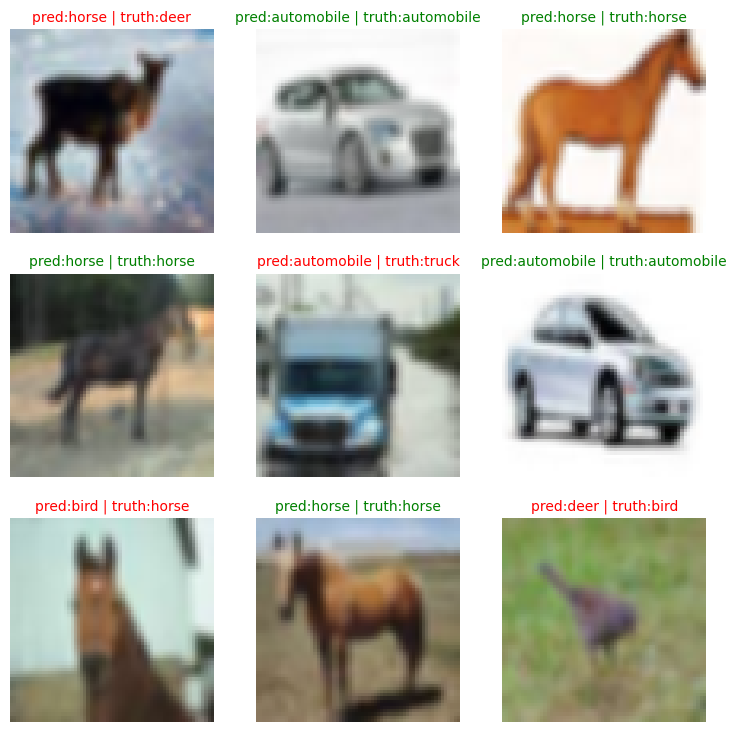

In [ ]:
#plot the predictions
plt.figure(figsize=(9,9))
nrows=3
ncols=3
for i,sample in enumerate(test_samples):
  plt.subplot(nrows,ncols,i+1)
  plt.imshow(sample.squeeze().permute(1,2,0))
  #find predictions(eg:sandels)
  pred_label = class_names[pred_classes[i]]
  #get truth label(in text form)
  truth_label = class_names[test_labels[i]]
  #create a title for the plot
  title_text = f"pred:{pred_label} | truth:{truth_label}"
  #check for equality between pred and truth and change color of title text
  if pred_label == truth_label:
    plt.title(title_text,fontsize=10,c="g")
  else:
    plt.title(title_text,fontsize=10,c="r")
  plt.axis("off")